In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [20]:
PATH = Path('data/pascal/')
list(PATH.iterdir())

[PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json')]

In [4]:
train_keys = json.load((PATH/'pascal_train2007.json').open())
train_keys.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
train_keys[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [6]:
train_keys[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [7]:
train_keys[CATEGORIES][:3]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'}]

In [63]:
# img = plt.imread(PATH/'VOCdevkit/Images')%
# %ls '{PATH}'/VOCdevkit/VOC2007/JPEGImages


jpegs = list( (PATH/'VOCdevkit/VOC2007/JPEGImages').iterdir());jpegs[:4]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg')]

data/pascal/VOCdevkit/VOC2007/JPEGImages/007460.jpg


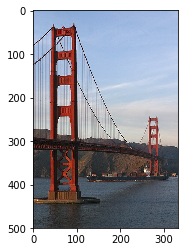

In [64]:
choice = np.random.choice(jpegs)
print(choice)
img = plt.imread(choice)
plt.imshow(img)

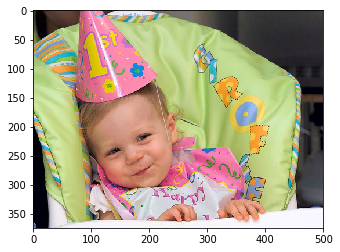

In [10]:
fig, ax = plt.subplots(figsize=None)
ax.imshow(img)
ax.draw??

In [29]:
train_keys[ANNOTATIONS][:1]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}]

# 1.  DATA LOADER

In [11]:
train_annotations = collections.defaultdict(lambda:[])

In [80]:
train_annotations_dict = collections.defaultdict(lambda:[])
for o in train_keys[ANNOTATIONS]: 
    if not o['ignore']:
        image_id = o['image_id']
        bb = o['bbox']
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        train_annotations_dict[image_id].append((bb,o['category_id']))
        
# train_keys[ANNOTATIONS][:1]

In [81]:
train_annotations_dict[12]


[(array([ 96, 155, 269, 350]), 7)]

In [14]:
def get_largest(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [96]:
largest_items = {a: get_largest(b) for a,b in train_annotations_dict.items() }

In [97]:
train_filenames_dict = {o['id']: o['file_name'] for o in train_keys[IMAGES]}; 
# train_filenames = train_keys[IMAGES] 

train_filenames[17]

'000017.jpg'

In [84]:
# train_keys[CATEGORIES][:1]
categories_dict = {o['id']: o['name']for o in train_keys[CATEGORIES]}; categories_dict[1]

'aeroplane'

In [91]:
train_ids = [o['id'] for o in train_keys[IMAGES]]; train_ids[0]

12

In [45]:
IMG_PATH = PATH/'VOCdevkit/VOC2007/JPEGImages'; IMG_PATH

PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')

In [87]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], categories_dict[c], sz=16)

def draw_idx(i):
    im_a = train_annotations_dict[i]
    im = open_image(IMG_PATH/train_filenames_dict[i])
    print(im.shape)
    draw_im(im, im_a)

(333, 500, 3)
data/pascal/VOCdevkit/VOC2007/JPEGImages/000017.jpg


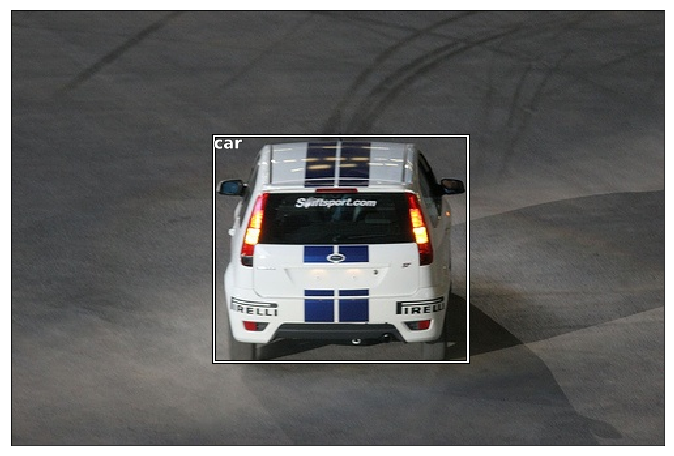

In [89]:
draw_idx(12); 
rndm_path = Path(IMG_PATH/train_filenames[17])
print(rndm_path)
# img = plt.imread(rndm_path)
# plt.imshow(img)
# os.path.exists(rndm_path)

In [100]:
df = pd.DataFrame({'fn': [train_filenames_dict[o] for o in train_ids ], 
                   'cats': [largest_items[o][1] for o in train_ids]}, 
                  columns=['fn', 'cats'])

In [101]:
df.head()

,fn,cats
0,000012.jpg,7
1,000017.jpg,13
2,000023.jpg,15
3,000026.jpg,7
4,000032.jpg,1


In [111]:
images_folder = PATH/'VOCdevkit/VOC2007/JPEGImages'

In [112]:
filename_category_csv = PATH/'tmp/cat.csv'
os.makedirs(PATH/'tmp',exist_ok=True)
df.to_csv(filename_category_csv, index=False) 

In [114]:
ImageClassifierData.from_csv??

In [116]:
f_model = resnet34
sz=224
bs=64

In [118]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)

In [124]:
md = ImageClassifierData.from_csv(PATH, images_folder, filename_category_csv, tfms=tfms)

In [125]:
md.trn_dl.get_batch([1])

OSError: No such file or directory: data/pascal/data/pascal/VOCdevkit/VOC2007/JPEGImages/000017.jpg